In [1]:
import pandas, numpy, theano, time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, TimeDistributedDense
from keras.layers.recurrent import LSTM
%matplotlib inline

Using Theano backend.


In [469]:
# convert an array of values into a sliding window dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

def get_predictions(kX, y, model, scaler):
    s_preds = scaler.inverse_transform(model.predict(kX))
    s_y     = scaler.inverse_transform(y)
    return s_y, s_preds

def get_RMSE(kX, y, model, scaler ):

    sy,spreds = get_predictions(kX, y, model, scaler)
    return np.sqrt(np.mean((sy[0]-spreds[:,0])**2))

def plot_predictions(dataset, ktrainX, trainY, ktestX, testY, model, scaler, look_back):
    sy_train, spreds_train = get_predictions(ktrainX, [trainY], model, scaler)
    sy_test,  spreds_test  = get_predictions(ktestX, [testY], model, scaler)
    
    plt.figure(figsize=(20,5))
    plt.plot(range(look_back, look_back+len(spreds_train)), spreds_train,
            label="predictions train", color="blue", lw=2)
    plt.plot(range(look_back, look_back+len(spreds_train)), sy_train[0],
            label="target train", color="blue", lw=2, alpha=.3)

    plt.plot(range(2*look_back+len(spreds_train), 2*look_back+len(spreds_train)+len(spreds_test)), 
             spreds_test, label="predictions test", color="red", lw=2)
    plt.plot(range(2*look_back+len(spreds_train), 2*look_back+len(spreds_train)+len(spreds_test)), 
             sy_test[0],         
             label="target test", color="red", lw=2, alpha=.3)
    
    plt.plot(scaler.inverse_transform(dataset), color="black", label="data", lw=3, alpha=.2)
    plt.legend(loc=2)
    plt.xlim(0,len(dataset))
    plt.xticks(range(0,len(dataset),2));
    plt.grid()
    
    
def rnn_experiment(dataset, train, test, look_back, lstm_size, batch_size, epochs, scaler):

    trainX, trainY = create_dataset(train, look_back)
    testX, testY   = create_dataset(test, look_back)
    ktrainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
    ktestX  = numpy.reshape(testX, (testX.shape[0], testX.shape[1],1))

    print "building RNN",
    model = Sequential()
    lstm = LSTM(lstm_size, input_dim=1, inner_activation="sigmoid")
    dense = Dense(1)
    model.add(lstm)
    model.add(dense)
    model.compile(loss='mean_squared_error', optimizer='adam')
    print "fitting RNN"
    mhist = model.fit(ktrainX, trainY, nb_epoch=epochs, batch_size=batch_size, verbose=0)

    sy_train, spreds_train = get_predictions(ktrainX, [trainY], model, scaler)
    sy_test,  spreds_test  = get_predictions(ktestX, [testY], model, scaler)
    print "train score: %.2f RMSE"%get_RMSE(ktrainX, [trainY], model, scaler)
    print "test score:  %.2f RMSE"%get_RMSE(ktestX, [testY], model, scaler)
        
    y, preds         = sy_test[0], spreds_test[:,0]
    y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
    print "trend prediction accuracy (test)  %.2f"%np.mean(y_delta==p_delta)

    y, preds         = sy_train[0], spreds_train[:,0]
    y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
    print "trend prediction accuracy (train) %.2f"%np.mean(y_delta==p_delta)
    
    plot_predictions(dataset, ktrainX, trainY, ktestX, testY, model, scaler, look_back)


## 1. load and preprocess dataset

- example and dataset obtained from [Time series prediction with LSTM Recurrent Neural Networks in Python with Keras](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

- dataset is scaled to [0,1]

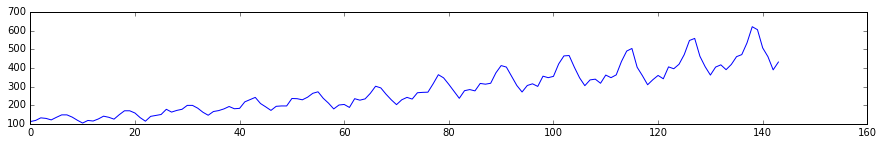

In [22]:
dataset = pandas.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataset.values
dataset = dataset.astype('float32')
plt.figure(figsize=(15,2))
plt.plot(dataset)


In [23]:
np.random.seed()

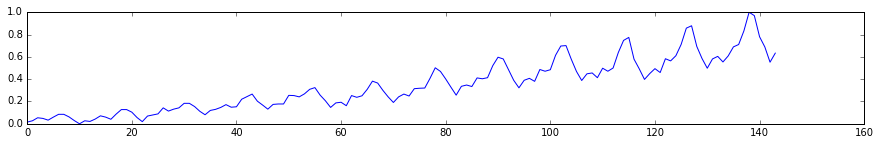

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.figure(figsize=(15,2))
plt.plot(dataset)

### split original signal into train and test

In [8]:
train_size  = int(len(dataset) * 0.67)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print train.shape, test.shape

(96, 1) (48, 1)


### creating time framed dataset

- reshape into $X=[x_{t-n},..., x_{t-1}, x_t]$ and $Y=x_{t+1}$
- reshape for Keras into 3D array (as for multiple signals although in this case we only use one signal)

In [332]:
look_back=3
trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test, look_back)
ktrainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
ktestX  = numpy.reshape(testX, (testX.shape[0], testX.shape[1],1))

In [333]:
print "full original signal     ", dataset.shape
print "original signal     train", train.shape, "test", test.shape
print "time framed signal  train", trainX.shape, "test", testX.shape
print "keras input signal  train", ktrainX.shape, "test", ktestX.shape

full original signal      (144, 1)
original signal     train (96, 1) test (48, 1)
time framed signal  train (93, 3) test (45, 3)
keras input signal  train (93, 3, 1) test (45, 3, 1)


In [334]:
print train[:10,0]
print trainX[:5]

[ 0.01544401  0.02702703  0.05405405  0.04826255  0.03281853  0.05984557
  0.08494207  0.08494207  0.06177607  0.02895753]
[[ 0.01544401  0.02702703  0.05405405]
 [ 0.02702703  0.05405405  0.04826255]
 [ 0.05405405  0.04826255  0.03281853]
 [ 0.04826255  0.03281853  0.05984557]
 [ 0.03281853  0.05984557  0.08494207]]


## 2. RNN definition and fitting

In [438]:
## build RNN
model = Sequential()
lstm = LSTM(50, input_dim=1, inner_activation="sigmoid")
dense = Dense(1)
model.add(lstm)
model.add(dense)
model.compile(loss='mean_squared_error', optimizer='adam')

In [443]:
## initialize weights on each layer using the initialization function configured for each layer
for layer in model.layers:
    layer.set_weights([layer.init(w.shape).get_value() for w in layer.get_weights()])

In [444]:
mhist = model.fit(ktrainX, trainY, nb_epoch=200, batch_size=10, verbose=0)

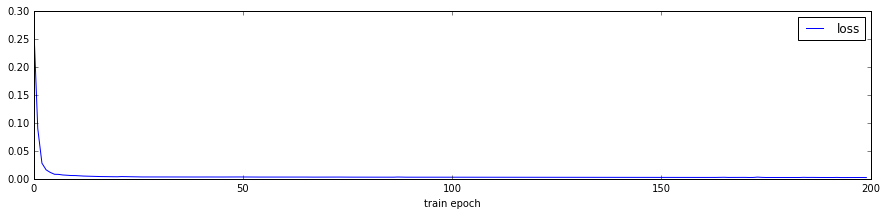

In [445]:
plt.figure(figsize=(15,3))
plt.plot(mhist.history["loss"], label="loss")
plt.xlabel("train epoch")
plt.legend()

### compute and visualize predictions and errors

train score: 24.21 RMSE
test score:  53.66 RMSE
trend prediction accuracy (test)  0.57
trend prediction accuracy (train) 0.55


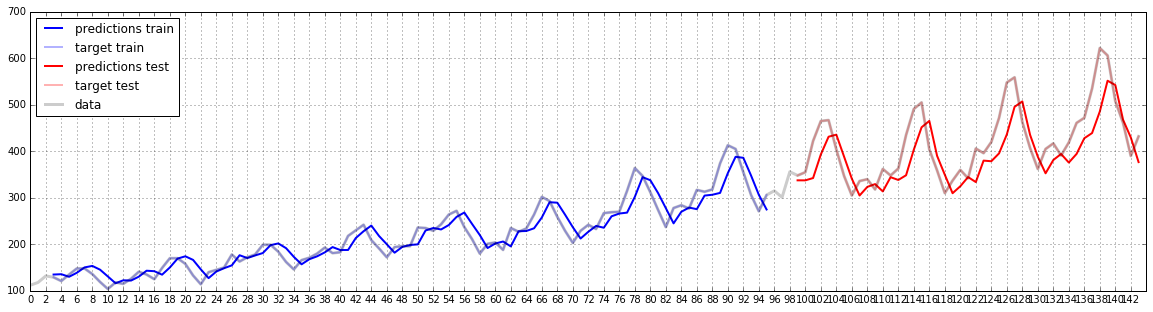

In [454]:
sy_train, spreds_train = get_predictions(ktrainX, [trainY], model, scaler)
sy_test,  spreds_test  = get_predictions(ktestX, [testY], model, scaler)
print "train score: %.2f RMSE"%get_RMSE(ktrainX, [trainY], model, scaler)
print "test score:  %.2f RMSE"%get_RMSE(ktestX, [testY], model, scaler)

y, preds         = sy_test[0], spreds_test[:,0]
y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
print "trend prediction accuracy (test)  %.2f"%np.mean(y_delta==p_delta)

y, preds         = sy_train[0], spreds_train[:,0]
y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
print "trend prediction accuracy (train) %.2f"%np.mean(y_delta==p_delta)

plot_predictions(dataset, ktrainX, trainY, ktestX, testY, model, scaler, look_back)


### compute trend prediction error (up or down) 

In [451]:
y = sy_test[0]
preds = spreds_test[:,0]
print "RMSE (check) %.2f"%np.sqrt(np.mean((y-preds)**2))

y_delta = (y[1:]>y[:-1])
p_delta = preds[1:]>preds[:-1]
print "trend prediction accuracy %.2f"%np.mean(y_delta==p_delta)

RMSE (check) 53.66
trend prediction accuracy 0.57


## 3. Inspection of  LSTM unit

following http://deeplearning.net/tutorial/lstm.html

**input gate**: $i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)$

**candidate state**: $\tilde{C}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c)$

**forget gate**: $f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)$

**state**: $C_t = i_t * \tilde{C}_t + f_t * C_{t-1}$

**output gate**: $o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$

**output**: $h_t = o_t * \tanh(C_t)$


### get functions for each layer from model

In [455]:
lstm_f   = theano.function([model.get_input_at(0)], lstm.get_output_at(0))
dense_ff = theano.function([model.get_input_at(0)], dense.get_output_at(0))
dense_f  = theano.function([dense.get_input_at(0)], dense.get_output_at(0))

In [456]:
lstm_out  = lstm_f(ktestX[0:1].astype(np.float32))
dense_out = dense_f(lstm_out)
print "lstm+dense         ", dense_out
print "directly from dense", dense_ff(ktestX[0:1])
print "from model         ", model.predict(ktestX[0:1])

lstm+dense          [[ 0.45088321]]
directly from dense [[ 0.45088321]]
from model          [[ 0.45088321]]


### get weights from model

In [457]:
def sigm(x):
    return 1./(1+np.exp(-x))
Wi = lstm.W_i.get_value()
Ui = lstm.U_i.get_value()
bi = lstm.b_i.get_value()
Wc = lstm.W_c.get_value()
Uc = lstm.U_c.get_value()
bc = lstm.b_c.get_value()
Wf = lstm.W_f.get_value()
Uf = lstm.U_f.get_value()
bf = lstm.b_f.get_value()
Wo = lstm.W_o.get_value()
Uo = lstm.U_o.get_value()
bo = lstm.b_o.get_value()

# from dense
dW1, db1 = dense.get_weights()

### use formulas to compute output

observe recurrence as $h_{t-1}$ and $C_{t-1}$ are fed back into the LSTM unit 

In [458]:
ht_minus1 = np.zeros(bi.shape)
ct_minus1 = np.zeros(bi.shape)
print "recurrent loops",
for i in range(ktestX.shape[1]):
    print i,
    xt  = ktestX[0,i]
    it  = sigm(xt.dot(Wi)+ht_minus1.dot(Ui)+bi)
    ctt = np.tanh(xt.dot(Wc)+ht_minus1.dot(Uc)+bc)
    ft  = sigm(xt.dot(Wf)+ht_minus1.dot(Uf)+bf)
    ct  = it*ctt + ft*ct_minus1
    ot  = sigm(xt.dot(Wo)+ht_minus1.dot(Uo)+bo)
    ht  = ot*np.tanh(ct)
    ht_minus1 = ht
    ct_minus1 = ct



recurrent loops 0 1 2


### verify formulas and keras implementation matches

In [459]:
predict = ht.dot(dW1) + db1
print "output at LSTM layer computed from formulas", ht
print "output at LSTM layer from keras model      ", lstm_f(ktestX[0:1].astype(np.float32))
print "\n-- MODEL PREDICTION --"
print "from formulas      ", predict
print "--"
print "lstm+dense         ", dense_out
print "directly from dense", dense_ff(ktestX[0:1])
print "from model         ", model.predict(ktestX[0:1])

output at LSTM layer computed from formulas [ 0.1201727  -0.32920841 -0.05309226 -0.33953916  0.09654439 -0.02834996
 -0.10660904 -0.18852013 -0.03203652  0.33296048  0.23438767 -0.24868805
  0.01933829 -0.00729266 -0.05014812 -0.25283058 -0.11019258  0.28603131
  0.04440735  0.11688281 -0.09081933 -0.10324247 -0.18933242  0.09743461
  0.18457961  0.08487472 -0.0007116  -0.25538729 -0.12964571  0.23048328
 -0.10673199  0.07043227 -0.04110239  0.04266093 -0.06235614 -0.06285664
  0.08184185  0.09292414 -0.04210578  0.05012219 -0.12930587  0.09889474
 -0.07738609  0.12104627  0.26677107 -0.0102525  -0.24299326  0.48777368
 -0.32148547 -0.16626207]
output at LSTM layer from keras model       [[ 0.1201727  -0.32920843 -0.05309225 -0.3395392   0.09654438 -0.02834998
  -0.10660902 -0.18852015 -0.03203652  0.33296052  0.2343877  -0.24868807
   0.0193383  -0.00729266 -0.05014812 -0.25283059 -0.11019259  0.28603134
   0.04440735  0.11688282 -0.09081932 -0.10324246 -0.18933244  0.09743459
   0.1

## 4. Fine tune RNN

observe with the network such as above, predictions can be seen as the input delayed ... so it is not really learning much

building RNN fitting RNN
train score: 22.23 RMSE
test score:  55.31 RMSE
trend prediction accuracy (test)  0.57
trend prediction accuracy (train) 0.52


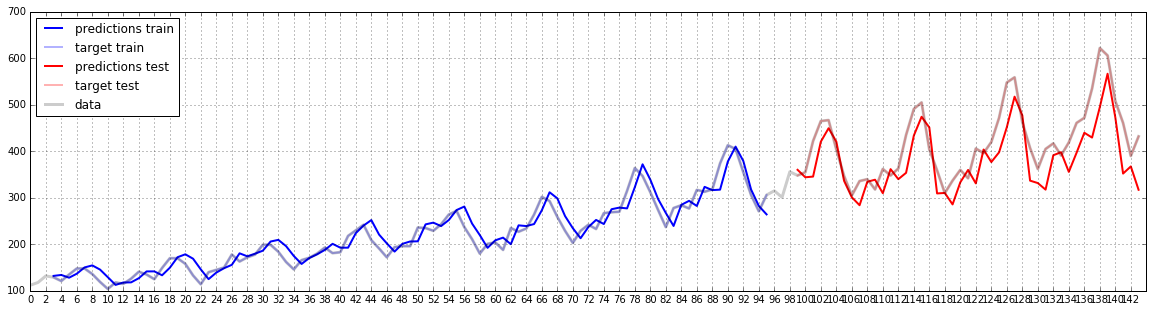

In [470]:
rnn_experiment(dataset, train, test, look_back=3, lstm_size=50, batch_size=10, epochs=200, scaler=scaler)

try out with different parameters

building RNN fitting RNN
train score: 22.72 RMSE
test score:  55.69 RMSE
trend prediction accuracy (test)  0.54
trend prediction accuracy (train) 0.57


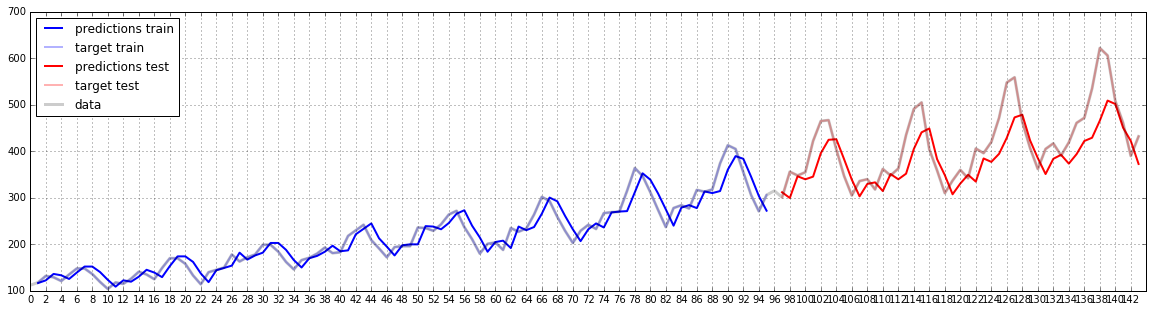

In [472]:
rnn_experiment(dataset, train, test, look_back=1, lstm_size=5, batch_size=10, epochs=200, scaler=scaler)

building RNN fitting RNN
train score: 29.69 RMSE
test score:  74.83 RMSE
trend prediction accuracy (test)  0.56
trend prediction accuracy (train) 0.59


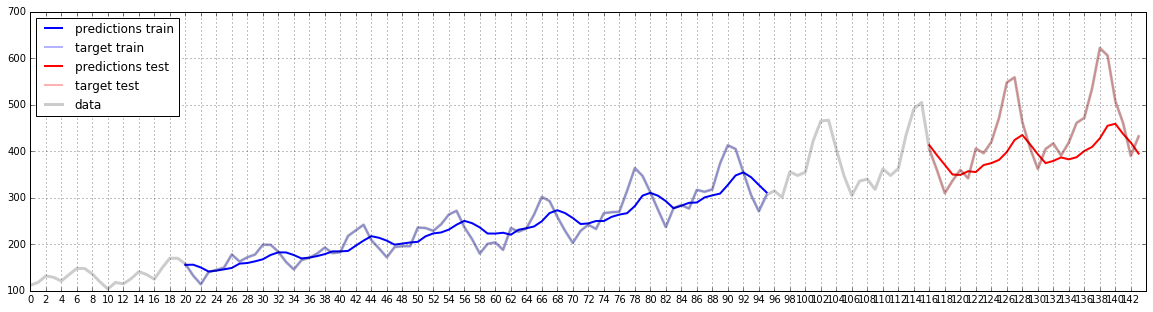

In [473]:
rnn_experiment(dataset, train, test, look_back=20, lstm_size=5, batch_size=10, epochs=200, scaler=scaler)

building RNN fitting RNN
train score: 19.92 RMSE
test score:  65.48 RMSE
trend prediction accuracy (test)  0.70
trend prediction accuracy (train) 0.77


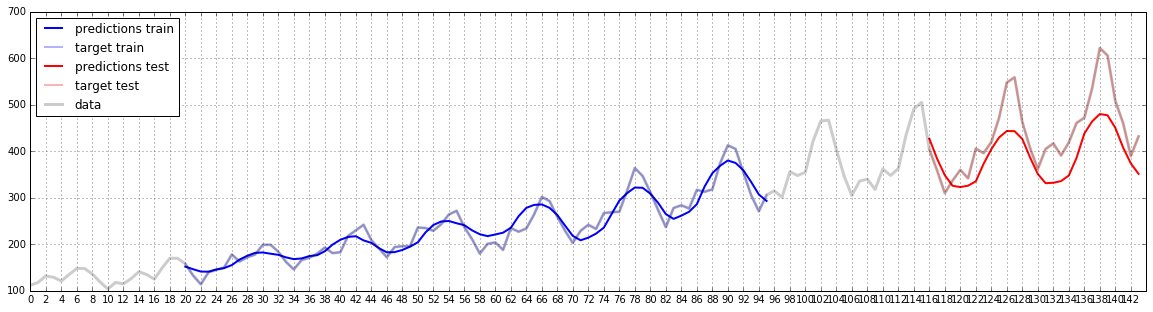

In [474]:
rnn_experiment(dataset, train, test, look_back=20, lstm_size=20, batch_size=10, epochs=200, scaler=scaler)

building RNN fitting RNN
train score: 16.97 RMSE
test score:  43.49 RMSE
trend prediction accuracy (test)  0.78
trend prediction accuracy (train) 0.71


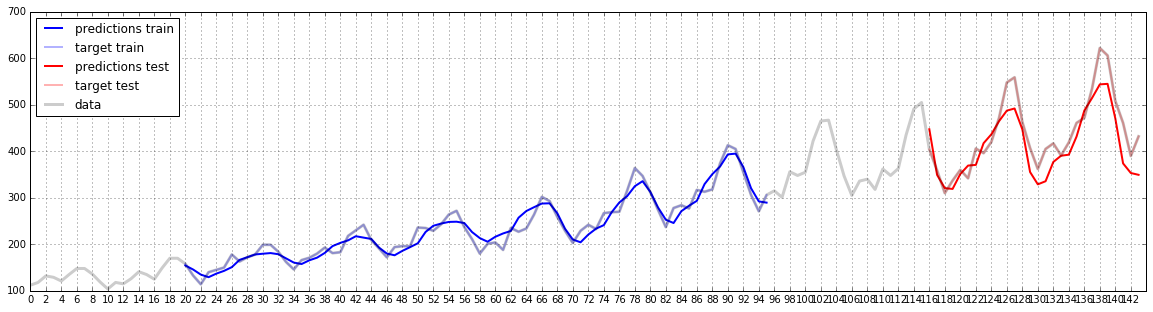

In [475]:
rnn_experiment(dataset, train, test, look_back=20, lstm_size=50, batch_size=10, epochs=200, scaler=scaler)

building RNN fitting RNN
train score: 10.25 RMSE
test score:  102.72 RMSE
trend prediction accuracy (test)  0.85
trend prediction accuracy (train) 0.77


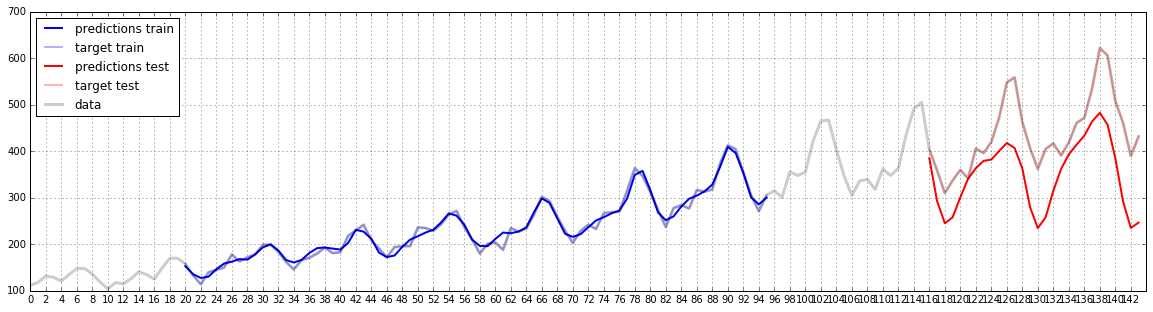

In [477]:
rnn_experiment(dataset, train, test, look_back=20, lstm_size=100, batch_size=10, epochs=500, scaler=scaler)

building RNN fitting RNN
train score: 10.08 RMSE
test score:  57.68 RMSE
trend prediction accuracy (test)  0.86
trend prediction accuracy (train) 0.73


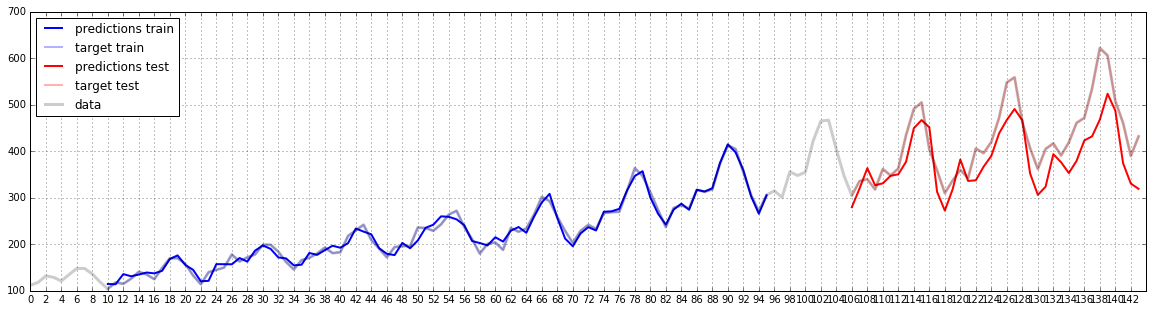

In [480]:
rnn_experiment(dataset, train, test, look_back=10, lstm_size=100, batch_size=10, epochs=500, scaler=scaler)